# [Non-parametric Bootstrap as a Bayesian Model](http://www.sumsar.net/blog/2015/04/the-non-parametric-bootstrap-as-a-bayesian-model/)

- Just because the bootstrap is a Bayesian model doesn’t mean it’s not also a frequentist model. 
- Just because the bootstrap is sometimes presented as making almost no assumptions, doesn’t mean it does.

The Bayesian approach models such data very naturally, whereas the bootstrap was originally designed for data modelled as i.i.d.

## The bootstrap as a Bayesian model

###  I. [(Rubin, 1981)](https://projecteuclid.org/euclid.aos/1176345338)


> The Bayesian bootstrap is the Bayesian analogue of bootstrap, where BB simulates the posterior distribution of the parameter (operationally and inferentially the methods are quite similar), whereas the bootstrap simulates the estimated sampling distribution of a statistic $\hat{\phi}$ estimating a parameter $\phi$.

> BB's advantage wrt to the resulting inferences about parameters: the BB generates likelihood statements about parameters rather than frequency statements about statistics under assumed values for parameters 

(page 4 for critics):
- unreasonable assumption that all possible distinct values of X are observed 
- unreasonable assumption that close values are associated with different probabilities of their occurrence $\to$ more complicated models and their Bayesian analogues (e.g. normal distribution, mixture models)

Let $d=(d_1,\dots,d_K)$ be a vector of all the possible values that the data $x=(x_1,\dots,x_N)$ could possibly take. Then, each $x_i$ is modeled as being drawn from the $d$ possible values where the probability of $x_i$ receiving a certain value from $d$ depends on a vector of probabilities $\pi=(\pi_1,\dots,\pi_K)$, where $\pi_1$ is the probability of drawing $d_1$. Using a categorical distribution:

$$x_i=d_{k_i}, k_i\sim Categorical(\pi)$$

Now we only need a prior distribution over the $\pi$'s for the model to be complete. That distribution is the Dirichlet distribution which is a distribution over proportions (vectors of real numbers between 0.0 and 1.0 that together sums to 1.0). A 2-dimensional Dirichlet is the same as a Beta distribution and is defined on the line where $\pi_1+\pi_2$ is always 1, the 3-dimensional Dirichlet is defined on the triangle where $\pi_1+\pi_2+\pi_3$ is always 1, and so on. A $K$-dimensional Dirichlet has $K$ parameters, where the expected proportion $\pi_1=\frac{\alpha_1}{\sum{\alpha}}$. The higher $\sum{\alpha}$ the more the distribution concentrates on the expected proportion, if it approaches 0, the distribution concentrates on points with few large proportions: 

![](http://www.sumsar.net/images/posts/2015-04-17-the-non-parametric-bootstrap-as-a-bayesian-model/dirichlet_plot.png)

As $\alpha \to (0,0,0)$ the density is “pushed” towards the edges of the triangle making proportions like (0.33,0.33,0.33) very unlikely. Using this type of prior will make the model consider it very likely apriori that the model will consider it impossible that $x$ takes on more than one value in $d$ unless there is data that shows otherwise. So using a Dirichlet achieves the hallmark of the bootstrap, that the model only considers values already seen in the data as possible. The full model is then:

$$ x_i \leftarrow d_{k_i}, k_i \sim Categorical(\pi), π \sim Dirichlet(0_1,\dots,0_K) $$

For binary data, $d=(0,1)$, the Bayesian bootstrap is the same as assuming $x_i \sim Bernoulli(p)$ with an improper $p \sim Beta(0,0)$ prior. A completely reasonable model, if you’re fine with the non-informative prior. Similarly it reduces to a categorical model when $d$ are a number of categories. For integer data, like count data, the Bayesian bootstrap implies treating each possible value as its own isolated category, disregarding any prior information regarding a relation between the values (such that three eggs are more that two eggs, but less than four). For continuous data the assumptions of the bootstrap feel a bit weird because we are leaving out obvious information: That the data is actually continuous and that a data point of, say, 3.1 should inform the model that values that are close (like 3.0 and 3.2) are also more likely.



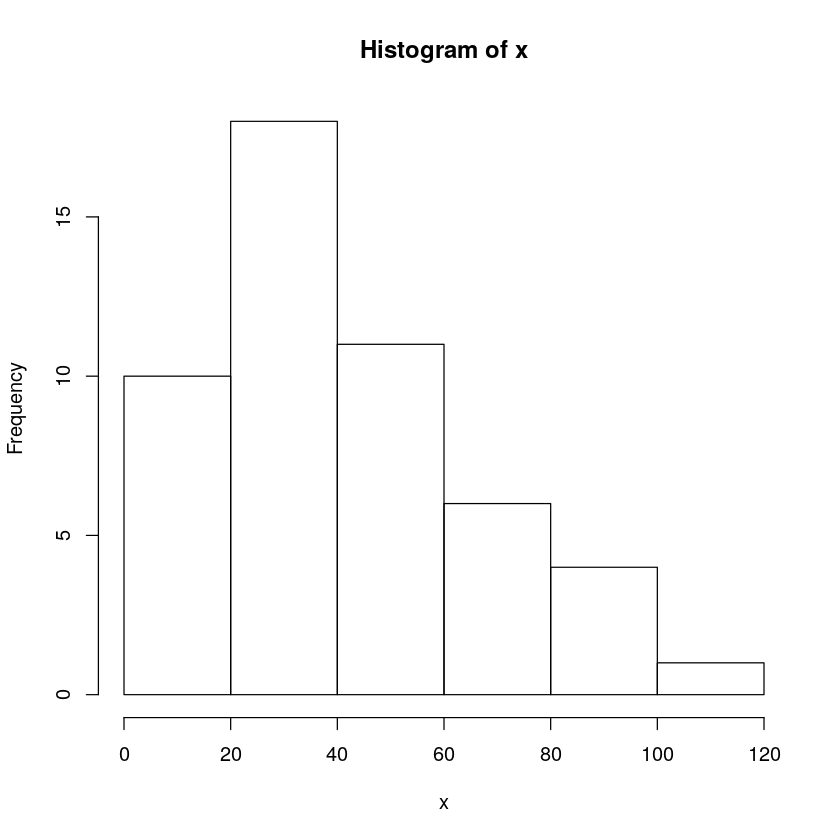

In [3]:
library(gtools)

# Bayesian bootstrap
mean.bb <- function(x, n) {
  apply(rdirichlet(n, rep(1, length(x))), 1, weighted.mean, x = x)
}

# standard bootstrap
mean.fb <- function(x, n) {
  replicate(n, mean(sample(x, length(x), TRUE)))
}

set.seed(1)
reps <- 100000
x <- cars$dist
hist(x)

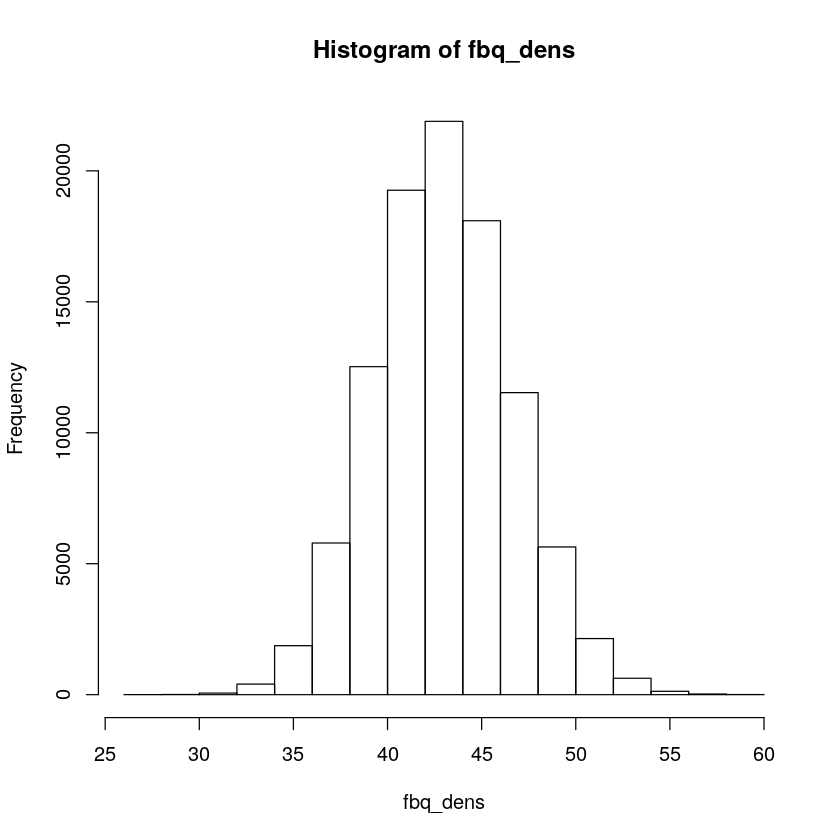

In [7]:
fbq_dens <- mean.fb(x, reps)
hist(fbq_dens)

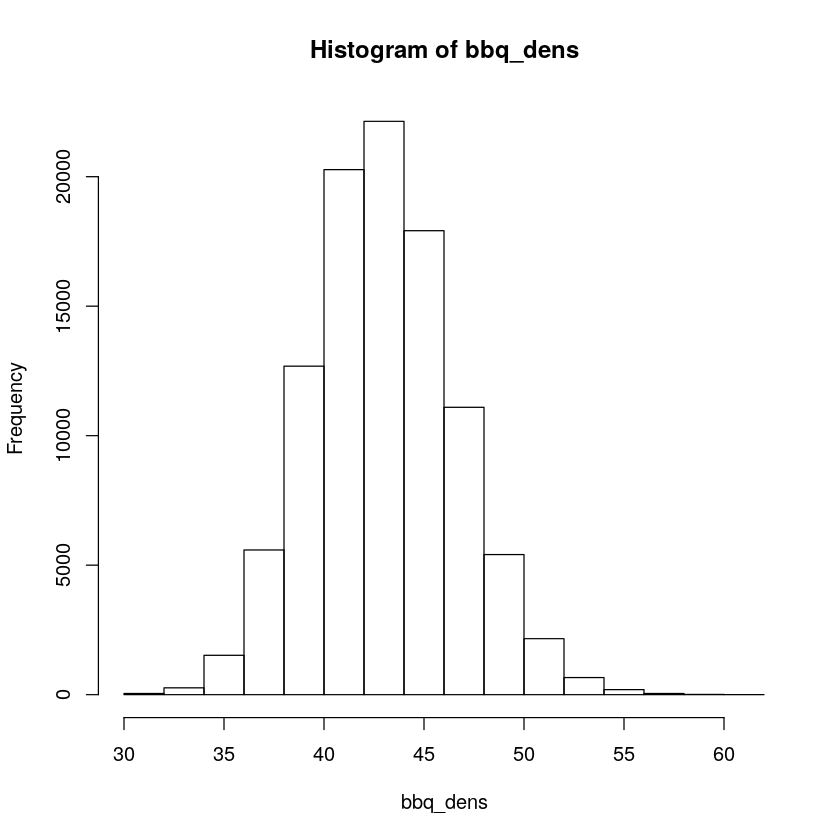

In [8]:
bbq_dens <- mean.bb(x, reps)
hist(bbq_dens)

In [1]:
system.time(fbq <- quantile((mean.fb(x, reps)), c(0.025, 0.075)))
system.time(bbq <- quantile((mean.bb(x, reps)), c(0.025, 0.075)))

   user  system elapsed 
  0.984   0.019   1.002 

   user  system elapsed 
  1.739   0.048   1.789 

### II. [(Gershman, Blei, 2011)](https://arxiv.org/pdf/1106.2697.pdf)

The Dirac delta distribution $x \sim \delta(x_0)$ and is a probability distribution with zero density except at $x_0$. The delta distribution can be seen as a Normal distribution where the standard deviation is approaching zero.

The geometric distribution is the distribution over how many “failures” there are in a number of Bernoulli trials before there is a success, where the one parameter is $p$, the relative frequency of success. 

$$Pr(X=k)=(1-p)^{k-1}p$$



Assume that the data $x=(x_1,\dots,x_N)$ is distributed as a mixture of delta distributions with $M$ components, where $\mu=(\mu_1,\dots,\mu_M)$ are the parameters of the $\delta$'s. The $\mu$'s are given a flat $Uniform(−\inf,\inf)$ distribution and the mixture probabilities $\pi=(\pi_1,\dots,\pi_M)$ are again given a $Dirichlet(0_1,\dots,0_M)$ distribution. Finally, $M$, the number of component distributions in the mixture, is given a $Geometric(p)$ distribution where $p$ is close to 1:


$$\begin{align}
&\begin{array}{l}
  x_i  \sim \delta(\mu_{k_i}) \\
  k_i  \sim \text{Categorical}(\pi) 
\end{array} 
  \bigg\} &\text{for $i$ in $1..N$} \\
&\mu_j  \sim \text{Uniform}(-\infty,\infty) &\text{for $j$ in $1..M$} \\
&\pi    \sim \text{Dirichlet}(0_1, \ldots, 0_M) & ~ \\
&M \sim \text{Geometric}(p)  &\text{with $p$ close to 1}
\end{align}$$

Assumptions: 

The data comes from a limited number of values (the $\mu$'s). A data point ($x_i$) comes from a specific value ($\mu_j$) with a probability ($\pi_j$), but what these probabilities $(\pi_1,\dots,\pi_M)$ are is very uncertain (due to the Dirichlet prior). The only part that remains is how many values ($M$) the data is generated from. This is governed by the Geometric distribution where $p$ can be seen as the probability that the current number of values ($M$) is the maximum number needed. When $p\approx 1$   the number of values will be kept to a minimum unless there is overwhelming evidence that another value is needed. But since the data is distributed as a pointy Dirac-delta distribution a set of data says there is no other possible way x could take on three different values.



### Three ways the classical bootstrap is a special case of the Bayesian bootstrap

####  It’s the Bayesian bootstrap but with discrete weights


![](http://www.sumsar.net/figures/2015-04-17-the-non-parametric-bootstrap-as-a-bayesian-model/unnamed-chunk-4.png)

It is sometimes written that _“the Bayesian bootstrap can be thought of as a smoothed version of the Efron bootstrap”_ (Lancaster, 2003), but you could equally well think of the classical bootstrap as a rough version of the Bayesian bootstrap

Nevertheless, as $N$ gets larger the classical bootstrap quickly becomes a good approximation to the Bayesian bootstrap, and similarly the Bayesian bootstrap quickly becomes a good approximation to the classical one.



#### It’s the posterior mean of the Bayesian bootstrap

For the classical bootstrap the underlying model is that __the distribution of the data is the distribution of the population__. 

For the Bayesian bootstrap __the values in the data define the support of the predictive distribution__, but how much each value contributes to the predictive depends on the probability weights which are, again, distributed as a $Dirichlet(1,\dots,1)$ distribution
(by taking a point estimate of the probability weights, say the posterior mean, we end up with the following weights: $(1/N,\dots,1/N)$, so each data point contributes equally to the posterior predictive, which is exactly the assumption of the classical bootstrap. 

So if you just look at the underlying models, and skip that part where you simulate a sampling distribution, the classical bootstrap can be seen as the posterior mean of the Bayesian bootstrap.

#### It’s the Bayesian bootstrap (II) but with a $Dirichlet (\infty, \dots, \infty)$ prior


![](http://www.sumsar.net/images/posts/2015-04-17-the-non-parametric-bootstrap-as-a-bayesian-model/dirichlet_high_alpha.png)

The model of the classical bootstrap can also be put as a special case of the model for the Bayesian bootstrap, version two. In that model the probability weights $\pi=(\pi_1,\dots,\pi_M)$ were given an uninformative $Dirichlet(\alpha_1,\dots,\alpha_M)$ distribution. In the limit of $\alpha to \infty$, the only possible weight becomes $\pi=(1/M,\dots,1/M)$, that is, the model is “convinced” that all seen values contribute exactly equally to the predictive distribution. 

That is, the same assumption as in the classical bootstrap. 
(Note that this only works if all seen data points are assumed unique as would most often be the case with continuous data.)



> In this sense, the bootstrap distribution represents an (approximate) nonparametric, noninformative posterior distribution for our parameter. But this bootstrap distribution is obtained painlessly — without having to formally specify a prior and without having to sample from the posterior distribution. Hence we might think of the bootstrap distribution as a “poor man’s” Bayes posterior. By perturbing the data, the bootstrap approximates the Bayesian effect of perturbing the parameters, and is typically much simpler to carry out.

## [Easy Bayesian Bootstrap in R](http://www.sumsar.net/blog/2015/07/easy-bayesian-bootstrap-in-r/)

Performs a Bayesian bootstrap and returns a sample of size n1 representing the
 posterior distribution of the statistic. Returns a vector if the statistic is
one-dimensional or a data.frame if the statistic is
multi-dimensional.

To generate a Bayesian bootstrap sample of size $n_1$, repeat the following $n_1$ times:

- Draw weights from a uniform Dirichlet distribution with the same dimension as the number of data points.
- Calculate the statistic, using the Dirichlet draw to weight the data, and record it.


Drawing from an n-dimensional uniform [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution#Gamma_distribution) can be done by drawing $Gamma(1,1)$ distributed numbers and normalizing these to sum to 1.0. As a $Gamma(1,1)$ distribution is the same as an $Exponential(1)$ distribution, the following two lines of R code implements drawing $n_1$ draws from an $n$-dimensional uniform Dirichlet distribution:



In [43]:
n = 3
n1 = 500
dirichlet_sample <- matrix( rexp(n * n1, 1) , ncol = n, byrow = TRUE)
dirichlet_sample <- dirichlet_sample / rowSums(dirichlet_sample)

print(head(dirichlet_sample))

           [,1]      [,2]        [,3]
[1,] 0.68504947 0.2080956 0.106854906
[2,] 0.54641349 0.1456664 0.307920123
[3,] 0.68891283 0.1587253 0.152361828
[4,] 0.26062533 0.7329309 0.006443803
[5,] 0.02583501 0.8799212 0.094243834
[6,] 0.49113814 0.4626882 0.046173617


_Calculate the statistic using a Dirichlet draw to weight the data:_

If you were doing a classical non-parametric bootstrap, you would use your resampled data to calculate a statistic. Instead, we will calculate statistic using the Dirichlet draw to weight the data. This is completely straightforward if the statistic can be calculated using weighted data: `weighted.mean(x, w)`, `lm(..., weights)`. 

For the many statistics that do not accept weights (e. g. median, cor), we will have to perform a second sampling step: sample from the data according to the probabilities defined by the Dirichlet weights, and  use this resampled data to calculate the statistic. 

Note that doing this second resampling step won’t work if the statistic changes with the sample size (e.g. the sample standard deviation, population standard deviation would be fine, however)


In [37]:
head(presidents)
n1 <- 3000
n2 <- 1000
n_data <- nrow(presidents)

order,president,height_cm
1,George Washington,188
2,John Adams,170
3,Thomas Jefferson,189
4,James Madison,163
5,James Monroe,183
6,John Quincy Adams,171


Generating a $n_1$ by $n_{data}$ matrix where each row is an $n_{data}$ dimensional Dirichlet draw:

In [38]:
weights <- matrix(rexp(n_data * n1, 1), ncol = n_data, byrow = TRUE)
weights <- weights / rowSums(weights)

bb_median <- rep(NA, n1)
for(i in 1:n1){
    data_sample <- sample(presidents$height_cm, size = n2, replace = TRUE, prob = weights[i,])
    bb_median[i] <- median(data_sample)}

Now `bb_median` represents the posterior median height, and we can do all the usual stuff, like calculating a 95% credible interval.

In [39]:
quantile(bb_median, c(0.025, 0.975))

2.5% 97.5% 
  178   183

If we were interested in the mean instead, we could skip resampling the data and use the weights directly, like this:



In [40]:
bb_mean <- rep(NA, n1)
for(i in 1:n1) {
    bb_mean[i] <- weighted.mean(presidents$height_cm, w = weights[i,])}

quantile(bb_mean, c(0.025, 0.975))

2.5%    97.5% 
177.6634 181.7759

In [45]:
bayes_boot <- function(data, statistic, n1 = 1000, n2 = 1000 , use_weights = FALSE, weight_arg = NULL, ...) {
    # Draw from a uniform Dirichlet dist. with alpha set to rep(1, n_dim).
    # Using the facts that you can transform gamma distributed draws into 
    # Dirichlet draws and that rgamma(n, 1) <=> rexp(n, 1)
    dirichlet_weights <- matrix( rexp(NROW(data) * n1, 1) , ncol = NROW(data), byrow = TRUE)
    dirichlet_weights <- dirichlet_weights / rowSums(dirichlet_weights)
    
    if(use_weights) {
        stat_call <- quote(statistic(data, w, ...))
        names(stat_call)[3] <- weight_arg
        boot_sample <- apply(dirichlet_weights, 1, function(w) {
            eval(stat_call)
        })
    } else {
        if(is.null(dim(data)) || length(dim(data)) < 2) { # data is a list type of object
            boot_sample <- apply(dirichlet_weights, 1, function(w) {
                data_sample <- sample(data, size = n2, replace = TRUE, prob = w)
                statistic(data_sample, ...)
            })
        } else { # data is a table type of object
            boot_sample <- apply(dirichlet_weights, 1, function(w) {
                index_sample <- sample(nrow(data), size = n2, replace = TRUE, prob = w)
                statistic(data[index_sample, ,drop = FALSE], ...)
            })
        }
    }
    
    if(is.null(dim(boot_sample)) || length(dim(boot_sample)) < 2) {
        # If the bootstrap sample is just a simple vector return it.
        boot_sample
    } else {
        # Otherwise it is a matrix. Since apply returns one row per statistic
        # let's transpose it and return it as a data frame.
        as.data.frame(t(boot_sample))
    }
}

Parameters: 
-   data -      The data as either a vector, matrix or data.frame.
-   statistic -  A function that accepts data as its first argument and possibly the weights as its second, if use_weights is TRUE. 
-   n1  -      The size of the bootstrap sample.
-   n2   -      The sample size used to calculate the statistic each bootstrap draw.
-   use_weights -  Whether the statistic function accepts a weight argument or               should be calculated using resampled data.
-   weight_arg  - If the statistic function includes a named argument for the                 weights this could be specified here.

In [2]:
presidents <- read.csv("american_presidents.csv")
bb_mean <- bayes_boot(presidents$height_cm, mean, n1 = 1000)

In [3]:
head(presidents)

order,president,height_cm
1,George Washington,188
2,John Adams,170
3,Thomas Jefferson,189
4,James Madison,163
5,James Monroe,183
6,John Quincy Adams,171


In [4]:
head(bb_mean)

[1] 179.0670 179.0924 179.4802 180.6704 180.5898 179.9812

In [5]:
quantile(bb_mean, c(0.025, 0.975))

2.5%    97.5% 
177.6334 181.7714

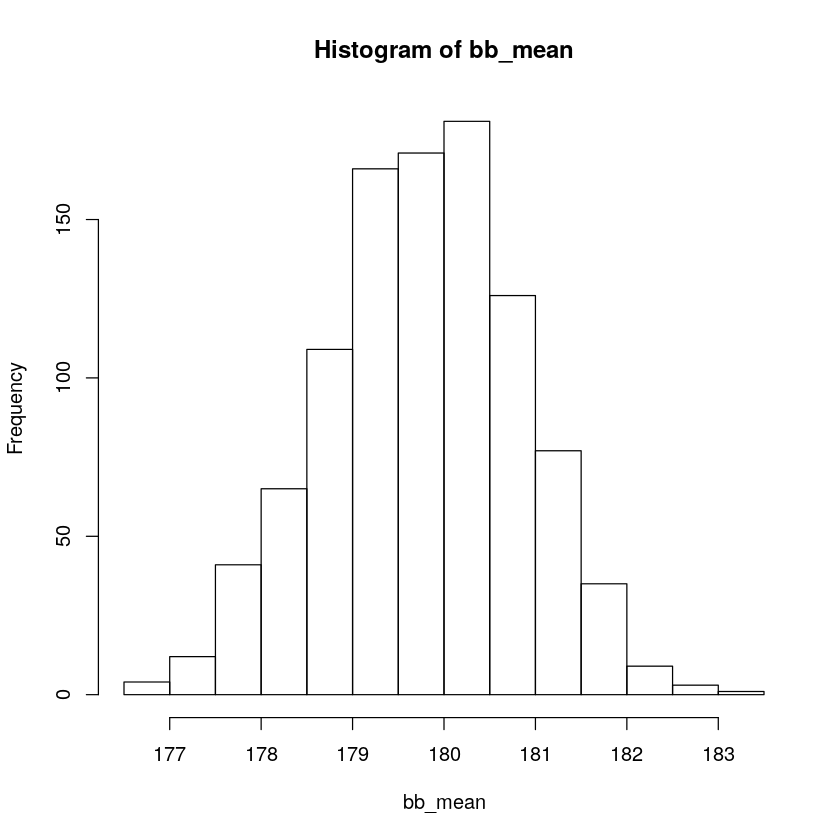

In [6]:
hist(bb_mean)

In [7]:
bb_linreg <- bayes_boot(presidents, function(data) {
    lm(height_cm ~ order, data)$coef
}, n1 = 1000)

In [12]:
head(bb_linreg)

(Intercept),order
181.9759,0.010303208
175.9805,0.171224738
180.5324,0.003294112
174.3695,0.268084063
174.5626,0.243549513
175.2498,0.230290940


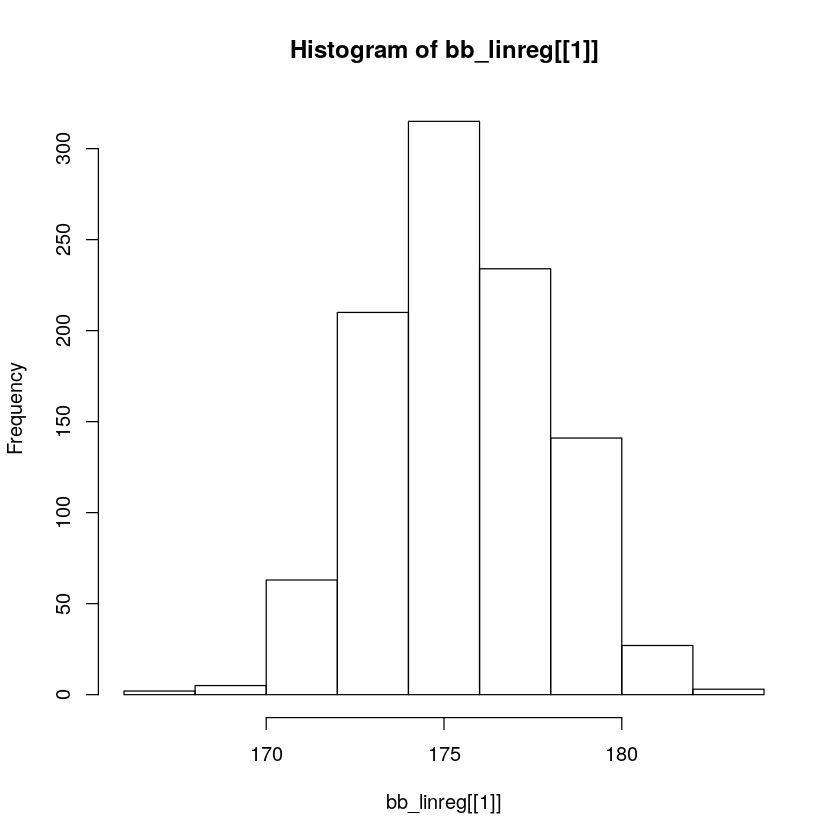

In [14]:
hist(bb_linreg[[1]])

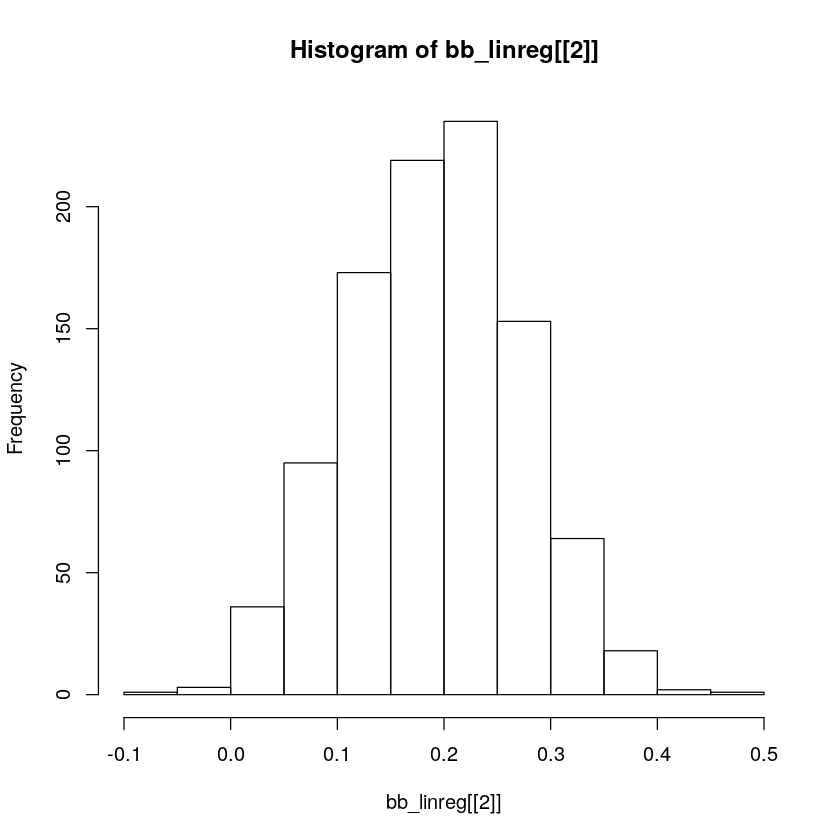

In [13]:
hist(bb_linreg[[2]])

In [17]:
quantile(bb_linreg$order, c(0.025, 0.975))

2.5%     97.5% 
0.0390299 0.3409736

In [19]:
library(ggplot2)

In [44]:
head(bb_linreg)

(Intercept),order
181.9759,0.010303208
175.9805,0.171224738
180.5324,0.003294112
174.3695,0.268084063
174.5626,0.243549513
175.2498,0.230290940


In [25]:
density(bb_linreg[[1]])


Call:
	density.default(x = bb_linreg[[1]])

Data: bb_linreg[[1]] (1000 obs.);	Bandwidth 'bw' = 0.549

       x               y            
 Min.   :165.0   Min.   :8.230e-06  
 1st Qu.:169.8   1st Qu.:1.579e-03  
 Median :174.7   Median :2.436e-02  
 Mean   :174.7   Mean   :5.147e-02  
 3rd Qu.:179.5   3rd Qu.:1.039e-01  
 Max.   :184.4   Max.   :1.567e-01  

In [30]:
top1 = which.max(density(bb_linreg[[1]])$y)
density(bb_linreg[[1]])$x[top1]

[1] 174.9328

In [31]:
top2 = which.max(density(bb_linreg[[2]])$y)
density(bb_linreg[[2]])$x[top2]

[1] 0.2244769

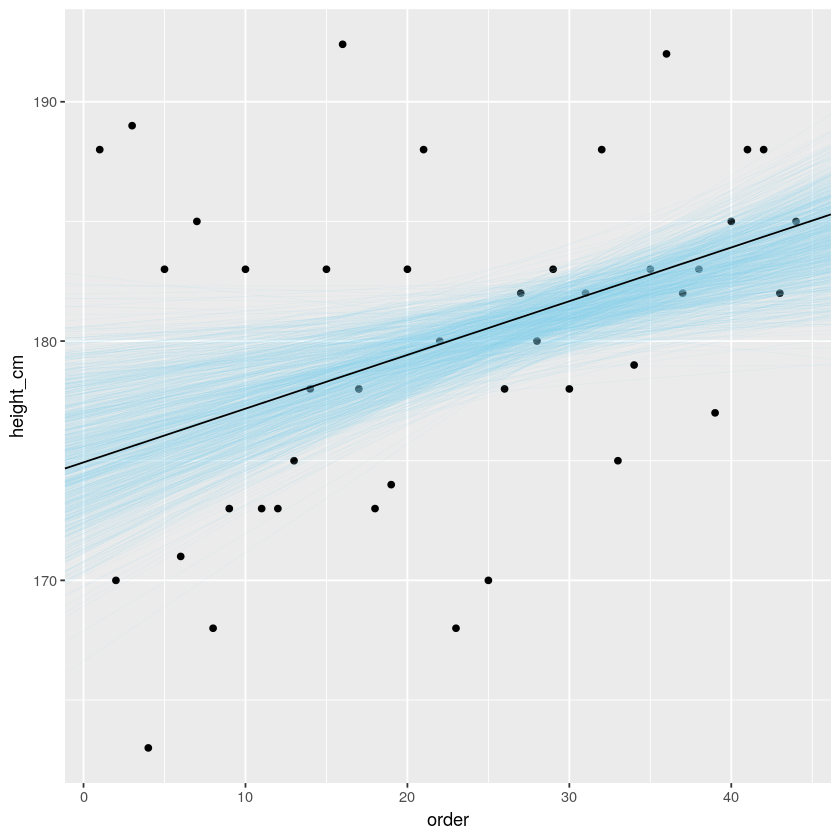

In [32]:
ggplot(presidents, aes(x = order, y = height_cm )) +    geom_point() +
  geom_abline(data = bb_linreg, aes(intercept = `(Intercept)`, slope = order),  size = 0.2, alpha = 0.1, color = "skyblue") +
  geom_abline(intercept = density(bb_linreg[[1]])$x[top1], slope = density(bb_linreg[[2]])$x[top2]) 

Let’s start by drawing some fake data from an exponential distribution with mean 1.0 and compare using the following methods to infer the mean:

In [62]:
set.seed(1337)
exp_data <- rexp(12, rate = 1)
exp_data

[1] 0.15264309 0.12948425 2.26328520 0.92279894 0.17010112 1.55464333
 [7] 0.13445828 0.01748711 1.04970589 1.41860749 1.61571964 0.12518835

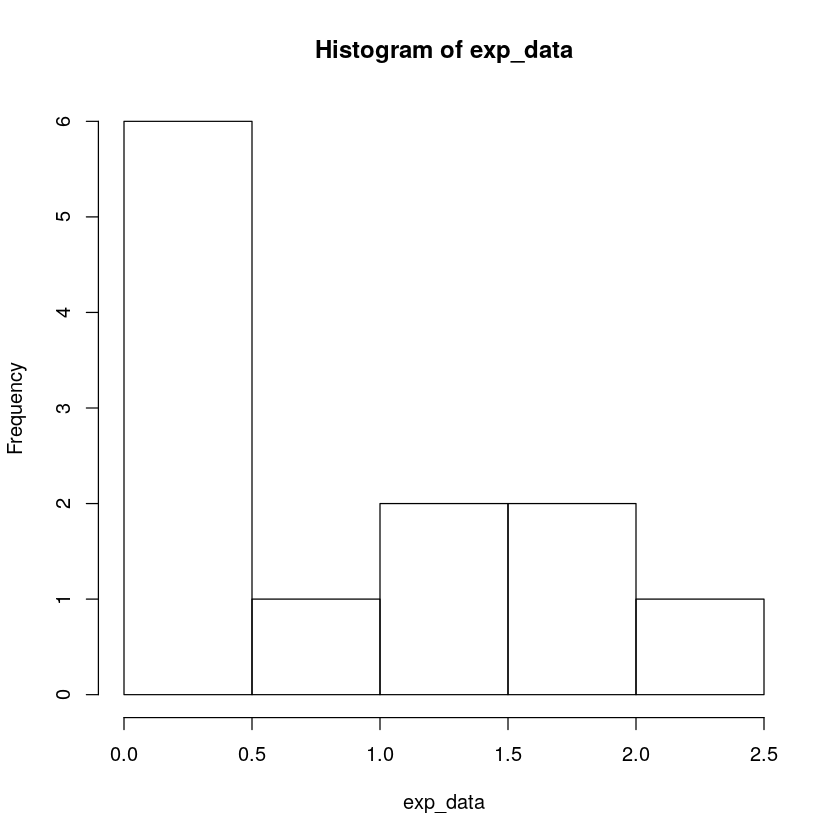

In [63]:
hist(exp_data)

1. The classical non-parametric bootstrap using boot from the `boot` package.

In [64]:
library(boot)
b_classic <- boot(exp_data, function(x, i) { mean(x[i])}, R = 10000)
b_classic[11]

$weights
 [1] 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 [7] 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333

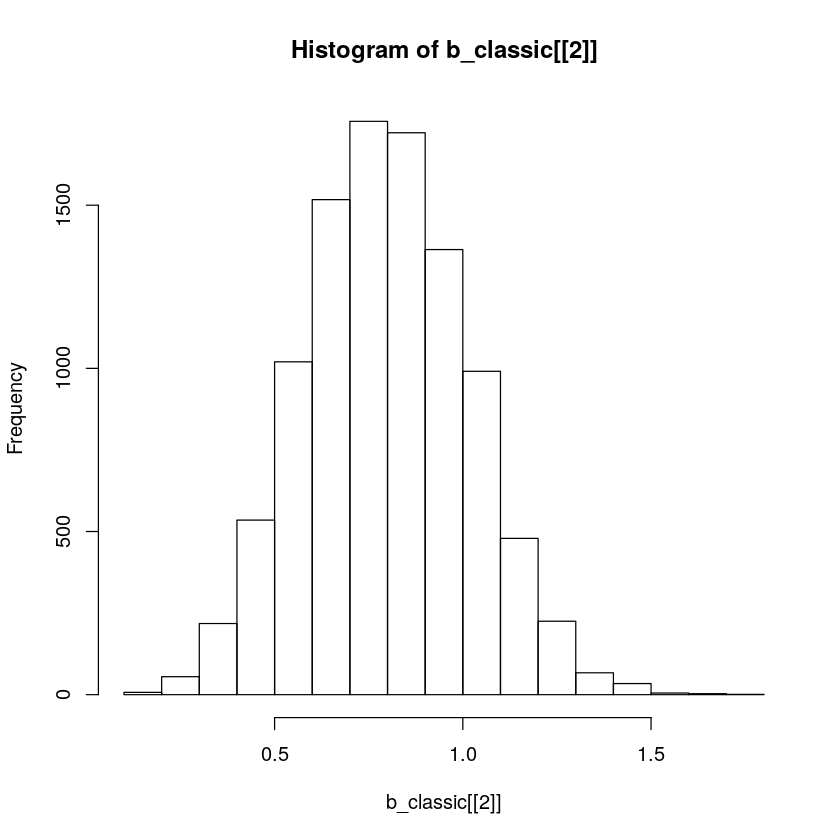

In [70]:
hist(b_classic[[2]])

2. Using `bayes_boot` with “two level sampling”, that is, sampling both weights and then resampling the data according to those weights.

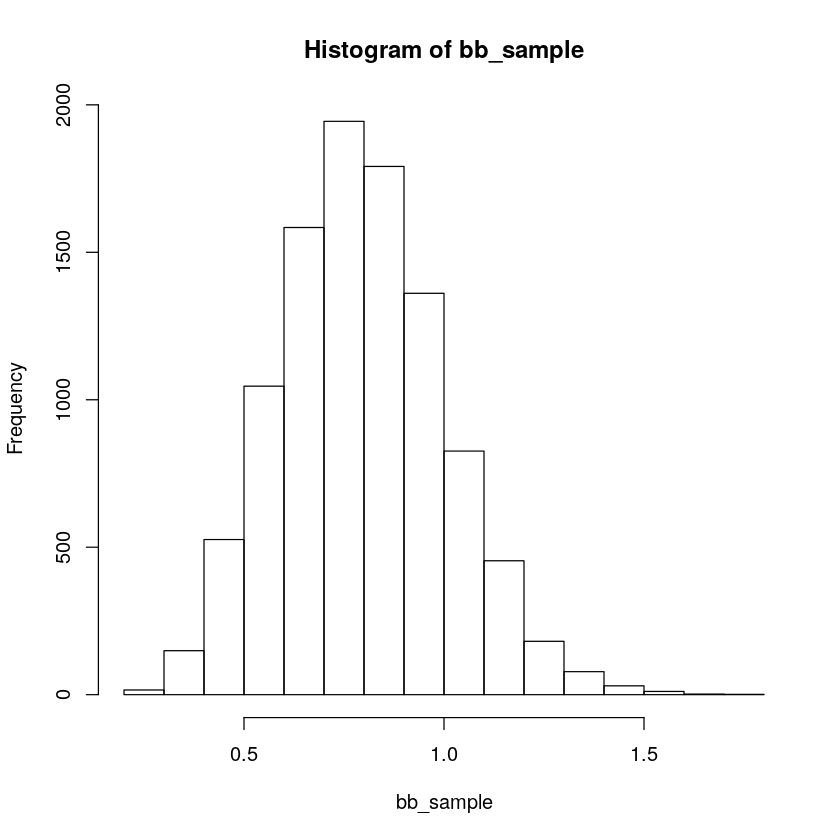

In [71]:
bb_sample <- bayes_boot(exp_data, mean, n1 = 10000, n2 = 1000)
hist(bb_sample)

3. Using `bayes_boot` with weights 

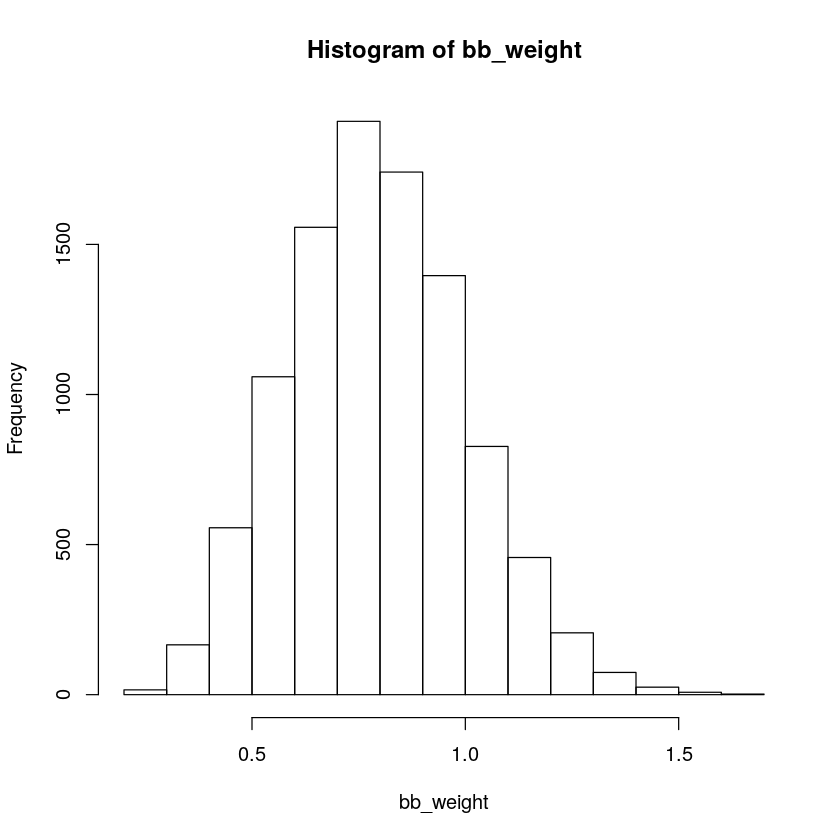

In [72]:
bb_weight <- bayes_boot(exp_data, weighted.mean, n1 = 10000, use.weights = TRUE, weight_arg = "w")
hist(bb_weight)

4. Assuming an exponential distribution (the “correct” distribution since we know where the data came from), with a flat prior over the mean.

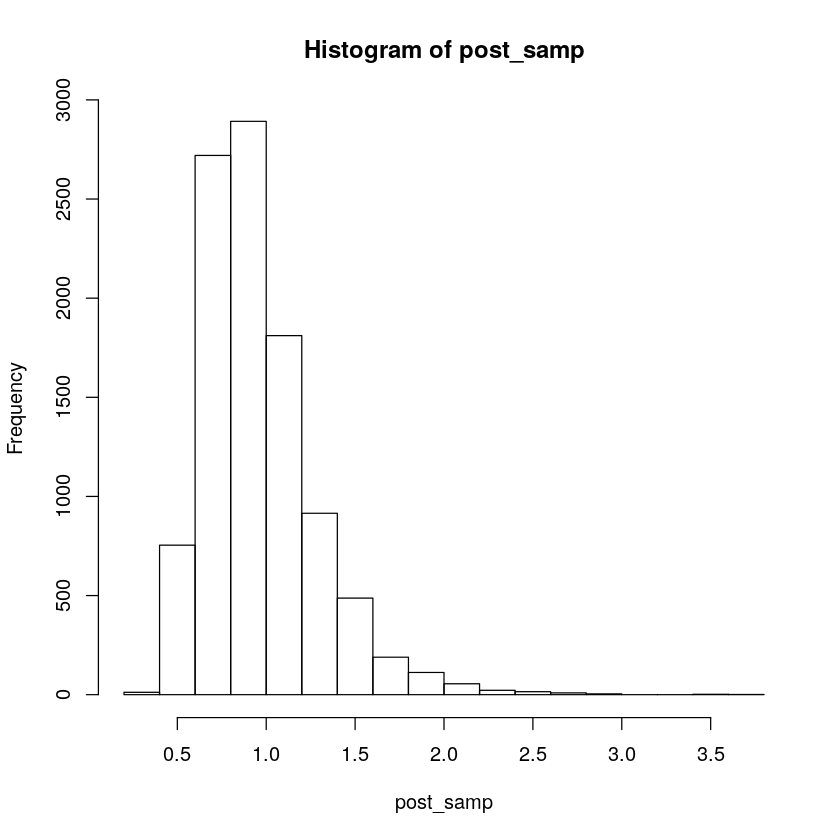

In [77]:
# Just a hack to sample from the posterior distribution when 
# assuming an exponential distribution with a Uniform(0, 10) prior

prior <- seq(0.001, 10, 0.001)
post_prob <- sapply(prior, function(mean) { prod(dexp(exp_data, 1/mean)) })
post_samp <- sample(prior, size = 10000, replace = TRUE, prob = post_prob)


hist(post_samp)

Finally, a slightly more complicated example, where we do Bayesian bootstrap analysis of LOESS (locally estimated scatterplot smoothing)  regression applied to the cars dataset. The loess function returns, among other things, a vector of fitted y values, one value for each x value in the data. These y values define the smoothed LOESS line and is what you would usually plot after having fitted a LOESS. Now we want to use the Bayesian bootstrap to gauge the uncertainty in the LOESS line. As the loess function accepts weighted data, we’ll simply create a function that takes the data with weights and returns the fitted y values.

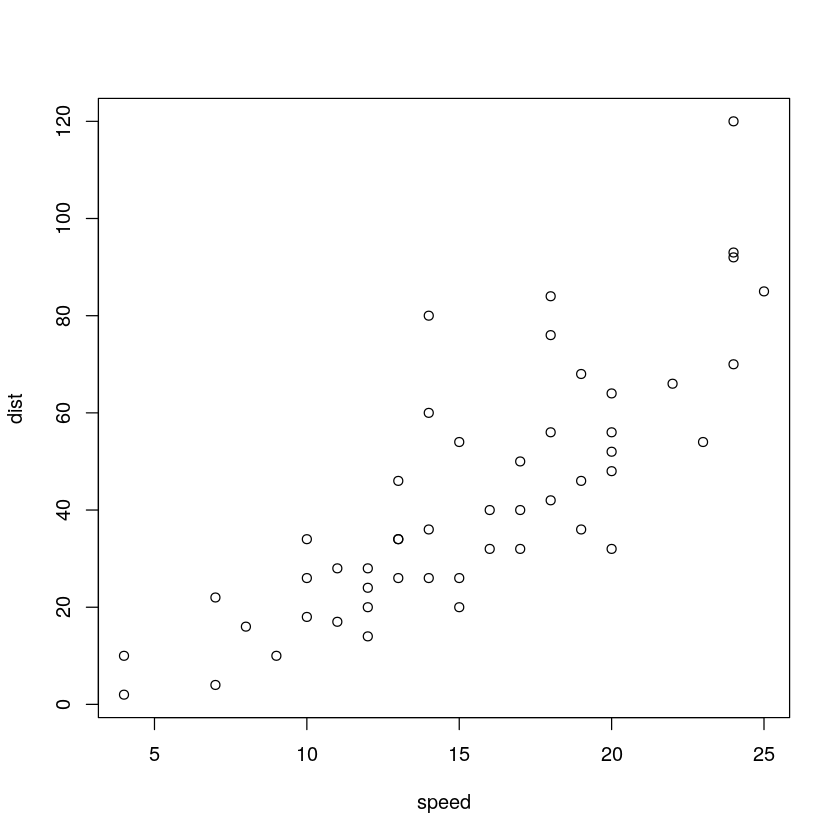

In [89]:
plot(cars)

In [78]:
boot_fn <- function(cars, weights) {
  loess(dist ~ speed, cars, weights = weights)$fitted
}

bb_loess <- bayes_boot(cars, boot_fn, n1 = 1000, use_weights = TRUE, weight_arg = "weights")

In [86]:
head(cars)

speed,dist
4,2
4,10
7,4
7,22
8,16
9,10


In [84]:
dim(cars)

[1] 50  2

In [87]:
head(bb_loess)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50
0.6113467,0.6113467,8.549617,8.549617,12.14695,16.43510,21.08604,21.08604,21.08604,26.33462,⋯,56.13485,56.13485,56.13485,68.50858,75.29532,82.64657,82.64657,82.64657,82.64657,90.53896
14.4927952,14.4927952,15.032133,15.032133,16.19651,17.88159,19.99846,19.99846,19.99846,22.50416,⋯,56.50682,56.50682,56.50682,70.35881,80.56851,93.12774,93.12774,93.12774,93.12774,107.74556
11.3381430,11.3381430,17.063962,17.063962,19.26954,21.62683,24.14091,24.14091,24.14091,26.90446,⋯,57.40024,57.40024,57.40024,68.29138,74.97595,82.52364,82.52364,82.52364,82.52364,90.97188
8.1504187,8.1504187,14.344603,14.344603,16.74118,19.28980,21.99815,21.99815,21.99815,24.69670,⋯,50.47084,50.47084,50.47084,64.25804,75.00027,88.36136,88.36136,88.36136,88.36136,104.29872
6.4513626,6.4513626,15.028478,15.028478,17.73916,20.30232,22.81939,22.81939,22.81939,25.02377,⋯,59.61204,59.61204,59.61204,68.06966,72.86742,78.01966,78.01966,78.01966,78.01966,83.57014
5.3740022,5.3740022,12.402603,12.402603,15.04345,17.90949,20.89164,20.89164,20.89164,23.82572,⋯,50.79440,50.79440,50.79440,65.18129,74.29829,84.80925,84.80925,84.80925,84.80925,96.78049


In [88]:
dim(bb_loess)

[1] 1000   50

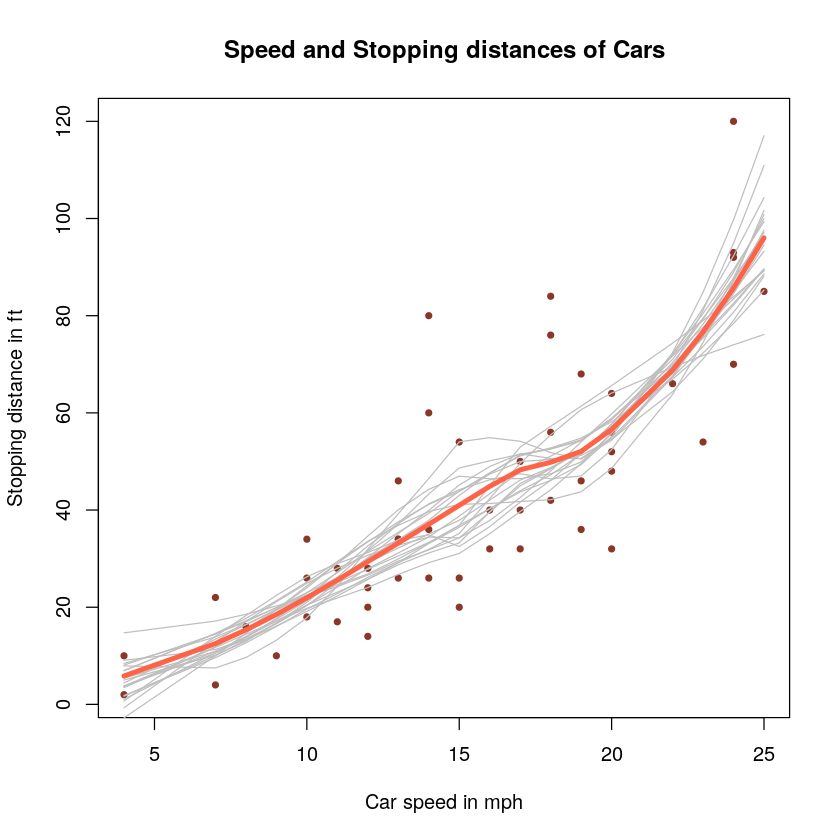

In [90]:
# Plotting the data
plot(cars$speed, cars$dist, pch = 20, col = "tomato4", xlab = "Car speed in mph",
     ylab = "Stopping distance in ft", main = "Speed and Stopping distances of Cars")

# Plotting a scatter of Bootstrapped LOESS lines to represent the uncertainty.
for(i in sample(nrow(bb_loess), 20)) {
  lines(cars$speed, bb_loess[i,], col = "gray")
}
# Finally plotting the posterior mean LOESS line
lines(cars$speed, colMeans(bb_loess, na.rm = TRUE), type ="l",
      col = "tomato", lwd = 4)

### `bayesboot`: [Easy Bayesian Bootstrap in R](https://github.com/rasmusab/bayesboot)

In [91]:
library(bayesboot)

In [98]:
heights <- presidents[[3]]
b1 <- bayesboot(heights, mean)
print(summary(b1))

Bayesian bootstrap

Number of posterior draws: 4000 

Summary of the posterior (with 95% Highest Density Intervals):
 statistic     mean       sd  hdi.low hdi.high
        V1 179.7927 1.040251 177.7356 181.8413

Quantiles:
 statistic    q2.5%     q25%   median     q75%   q97.5%
        V1 177.7127 179.0992 179.7989 180.4965 181.8255

Call:
 bayesboot(data = heights, statistic = mean)


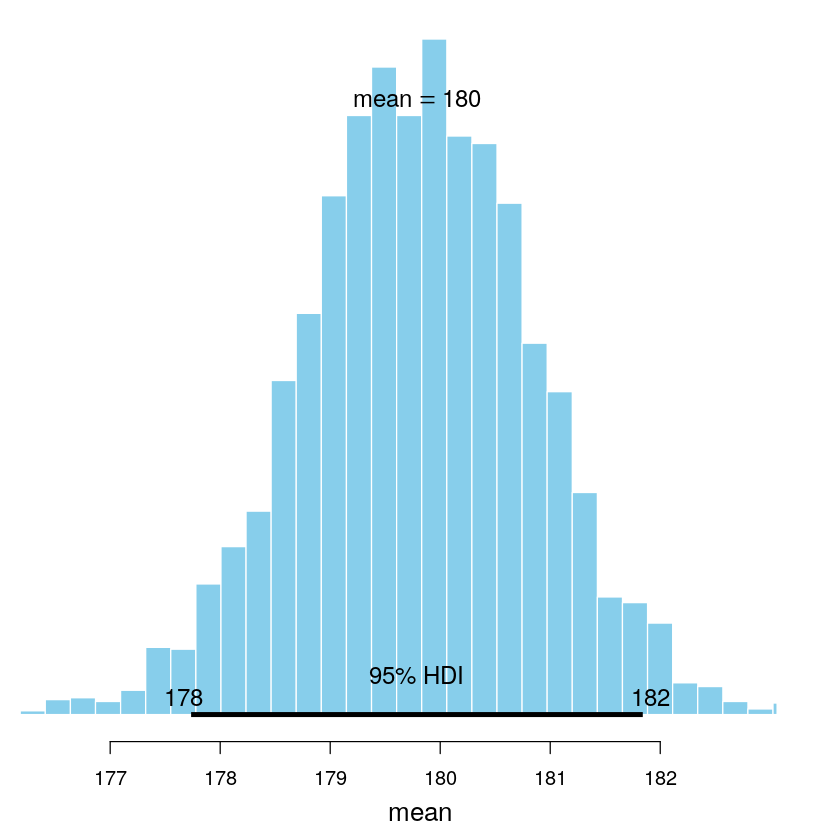

In [99]:
plot(b1)

In [102]:
b2 <- bayesboot(heights, weighted.mean, use.weights = TRUE)
print(summary(b2))

Bayesian bootstrap

Number of posterior draws: 4000 

Summary of the posterior (with 95% Highest Density Intervals):
 statistic     mean       sd  hdi.low hdi.high
        V1 179.7916 1.035555 177.7979  181.877

Quantiles:
 statistic    q2.5%     q25%   median     q75%   q97.5%
        V1 177.6903 179.1111 179.8031 180.4886 181.8092

Call:
 bayesboot(data = heights, statistic = weighted.mean, use.weights = TRUE)


In [103]:
mean(c(b2[,1] > 175.9, TRUE, FALSE))

[1] 0.9992504

#### Comparing two groups

If we want to compare the means of two groups, we will have to call ``bayesboot`` twice with each dataset and then use the resulting samples to calculate the posterior difference

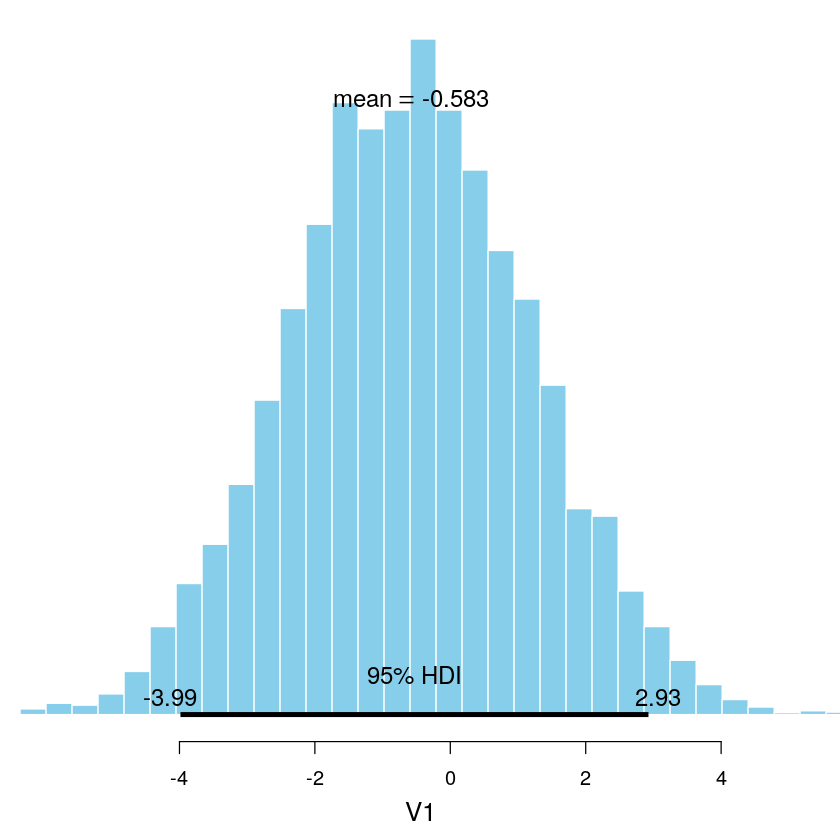

In [104]:
heights_opponents <- c(182, 180, 180, 183, 177, 173, 188, 185, 175)

# Running the Bayesian bootstrap for both datasets
b_presidents <- bayesboot(heights, weighted.mean, use.weights = TRUE)
b_opponents  <- bayesboot(heights_opponents, weighted.mean, use.weights = TRUE)

# Calculating the posterior difference
# (here converting back to a bayesboot object for pretty plotting)
b_diff <- as.bayesboot(b_presidents - b_opponents)
plot(b_diff)

####  `cars` example

In [105]:
boot_fn <- function(cars, weights) {
  loess(dist ~ speed, cars, weights = weights)$fitted
}

bb_loess <- bayesboot(cars, boot_fn, use.weights = TRUE)